# Hierarchical Ar(1) on a Grid Test with STAN

In this notebook, we will test the compositional score matching on a hierarchical problem defined on a grid.
- The observations are on grid with `n_grid` x `n_grid` points.
- The global parameters are the same for all grid points with hyper-priors:
$$ \alpha \sim \mathcal{N}(0, 1) \quad
  \mu_\beta \sim \mathcal{N}(0, 1) \quad
  \log\text{std}_\beta \sim \mathcal{N}(-1, 1);$$

- The local parameters are different for each grid point
$$ \beta_{i,j}^\text{raw} \sim \mathcal{N}(\mu_\beta, \text{std}_\beta^2), \qquad \beta_{i,j} = 2\operatorname{sigmoid}(\beta_{i,j}^\text{raw})-1$$

-  In each grid point, we have a time series of `T` observations. For the time beeing, we fix $\sigma=1$.
$$ y_{i,j} \sim \mathcal{N}(\alpha + \beta_{i,j}y_{i,j-1}, \sigma^2), y_{i,0} \sim \mathcal{N}(0, \sigma^2)$$
- We observe $T=5$ time points for each grid point. We can also amortize over the time dimension.

In [ ]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np

os.environ['KERAS_BACKEND'] = 'torch'
from bayesflow import diagnostics

from problems.ar1_grid_stan import get_stan_posterior
from problems.ar1_grid import Prior
from problems import plot_shrinkage, visualize_simulation_output

In [ ]:
N = 32*32

prior = Prior()

global_param_names = prior.global_param_names
local_param_names = prior.get_local_param_names(N)

In [ ]:
results = []
for _ in range(100):
    test = prior.sample(1, n_local_samples=N)
    results.append(test['data'][0])
    #visualize_simulation_output(test['data'][0])

#print(test['global_params'])
results = np.stack(results, axis=0)

visualize_simulation_output(np.max(results, axis=0))
visualize_simulation_output(np.min(results, axis=0))
visualize_simulation_output(np.mean(results, axis=0))
visualize_simulation_output(np.std(results, axis=0))

In [ ]:
np.random.seed(42)

global_posteriors = []
local_posteriors = []

true_global = []
true_local = []

start = time.time()
for i in range(100):
    print(i)
    sample = prior.sample(1, n_local_samples=N)
    true_global.append(sample['global_params'].flatten().cpu().numpy())
    true_local.append(sample['local_params'].flatten().cpu().numpy())
    sim_test = sample['data'][0].cpu().numpy()

    global_posterior, local_posterior = get_stan_posterior(sim_test, sigma_noise=prior.simulator.sigma_noise)
    global_posteriors.append(global_posterior)
    local_posteriors.append(local_posterior)
end = time.time()
print(end - start)

# make numpy arrays
global_posterior = np.stack(global_posteriors, axis=0)
local_posterior = np.stack(local_posteriors, axis=0).transpose(0, 2, 1)

true_global = np.stack(true_global, axis=0)
true_local = np.stack(true_local, axis=0)

In [20]:
np.save(f'problems/ar1/global_posterior_{N}.npy', global_posterior)
np.save(f'problems/ar1/local_posterior_{N}.npy', local_posterior)
np.save(f'problems/ar1/true_global_{N}.npy', true_global)
np.save(f'problems/ar1/true_local_{N}.npy', true_local)

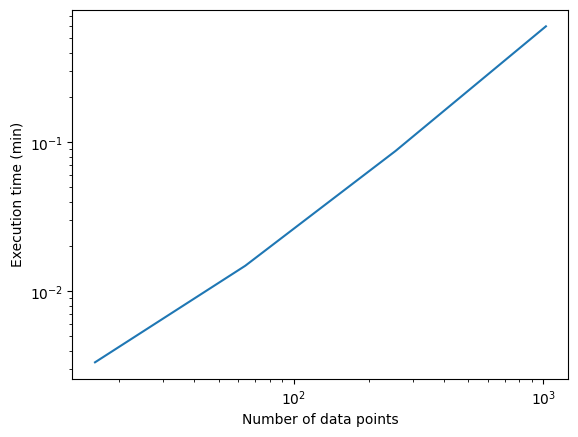

In [19]:
# timing (10 datasets)
# 4x4: 2.03s / 10 = 0.20s
# 8x8: 8.89s / 10 = 0.89s
# 16x16: 52.52s / 10 = 5.25s
# 32x32: 3600s / 100 = 36s

data_n = [4*4, 8*8, 16*16, 32*32]
time_n = np.array([0.2, 0.89, 5.25, 36]) / 60.

plt.plot(data_n, time_n)
plt.xlabel('Number of data points')
plt.ylabel('Execution time (min)')
plt.yscale('log')
plt.xscale('log')
#plt.xticks(data_n)
plt.show()

# Plotting

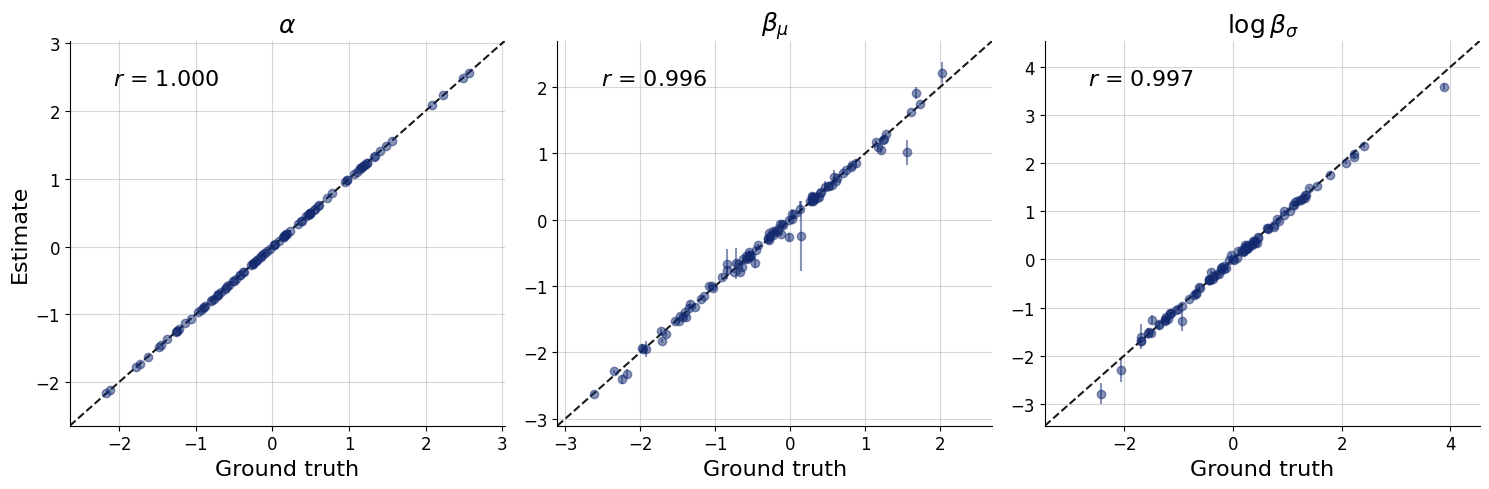

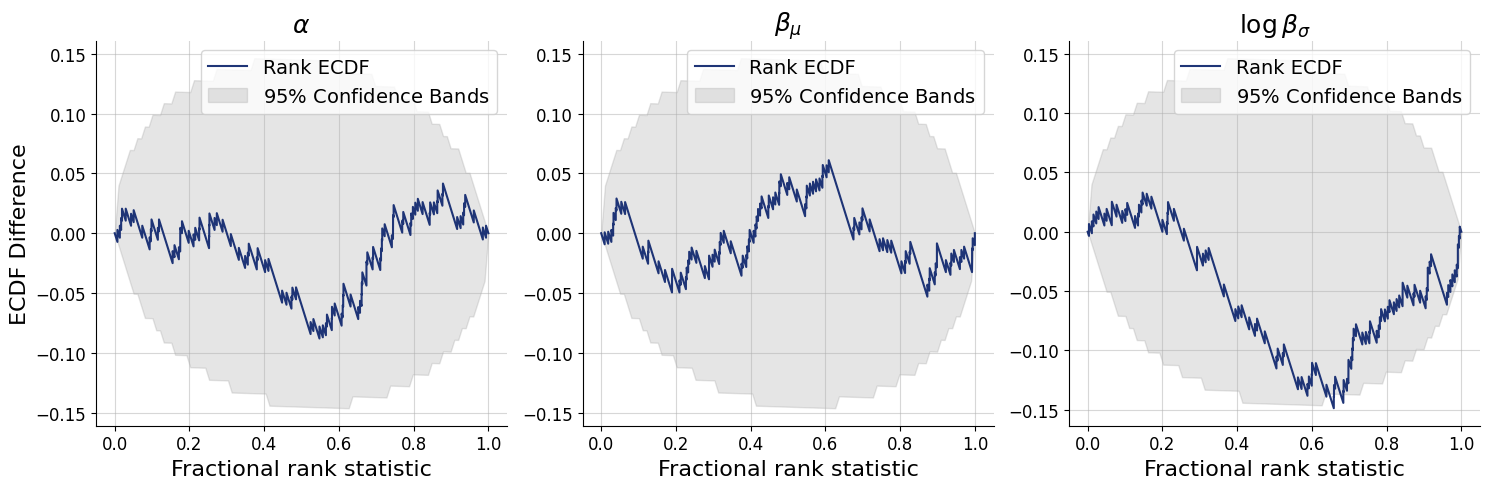

In [21]:
diagnostics.recovery(global_posterior, true_global, variable_names=global_param_names)
diagnostics.calibration_ecdf(global_posterior, true_global, difference=True, variable_names=global_param_names);

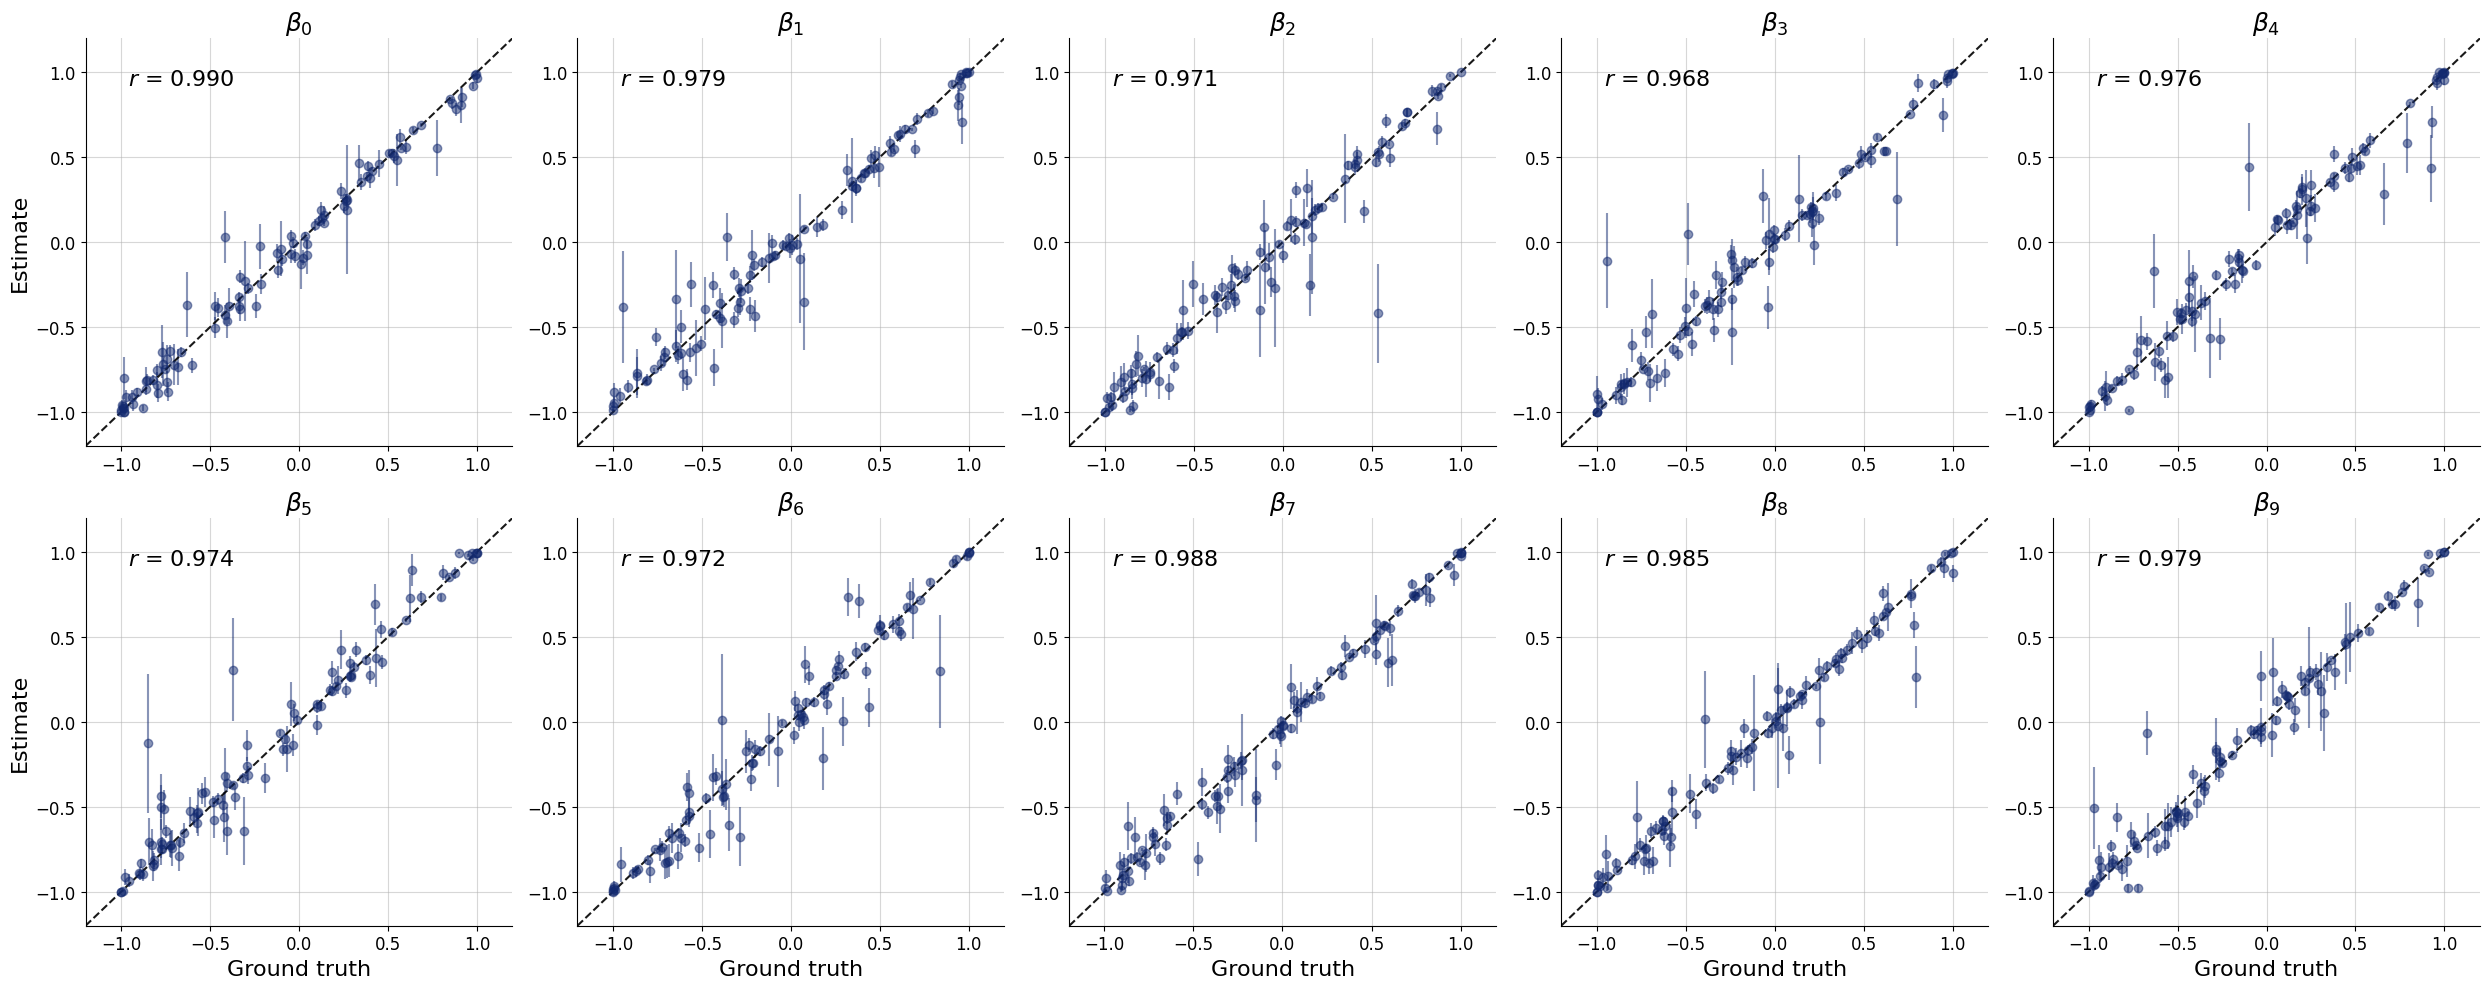

In [22]:
diagnostics.recovery(local_posterior[:, :, :10], true_local[:, :10], variable_names=local_param_names[:10]);

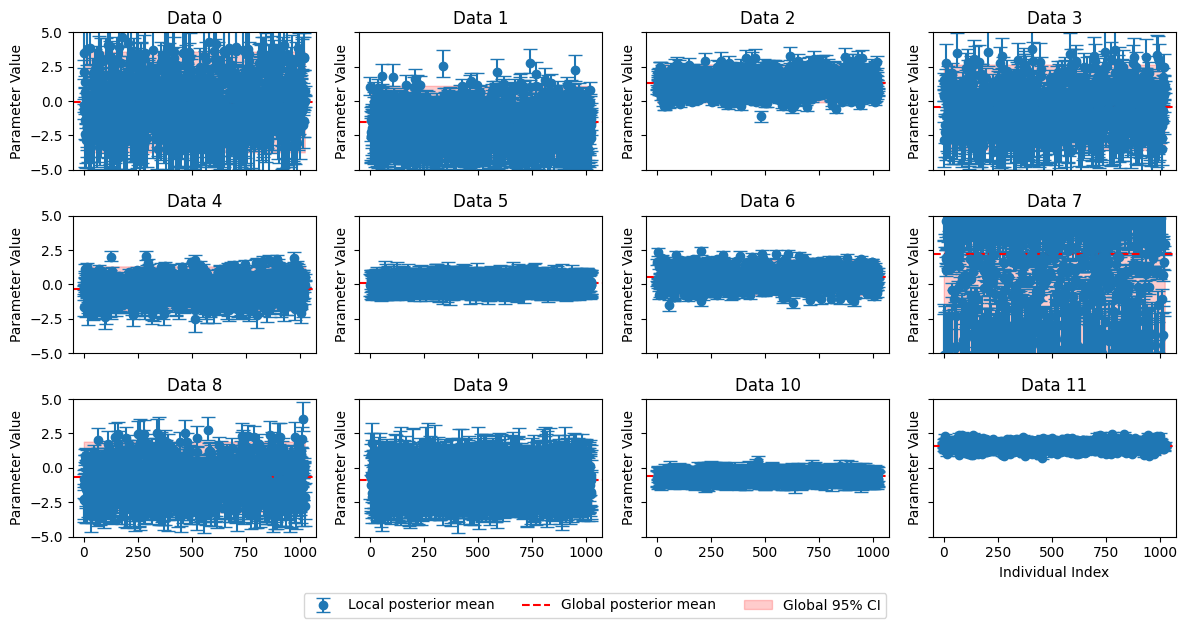

In [23]:
local_posterior_raw = prior.back_transform_local_params(local_posterior)

plot_shrinkage(global_posterior[:12, :, 1:], local_posterior_raw[:12, :, :, np.newaxis], min_max=(-5, 5))